In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt

def binnedEntropy(data, xMin, xMax, nBox):
    nData = len(data)
    pointDict = dict()
    dx = (xMax - xMin) / nBox
    for x in data:
        key = tuple(np.divide(x, dx).astype(int))
        if key in pointDict:
            pointDict[key] += 1
        else:
            pointDict[key] = 1
    
    relArea = len(pointDict) / nBox**2
    binEntr = np.sum([-binVal/nData * np.log(binVal/nData) for binVal in pointDict.values()])
    
    return relArea, binEntr

def binnedEntropyCurves(data, nBoxLst):
    xMin = np.min(data, axis = 0) - 0.0001
    xMax = np.max(data, axis = 0) + 0.0001
    return np.array([binnedEntropy(data, xMin, xMax, nBox) for nBox in nBoxLst])

def binnedEntropyCurvesSurrogate(data, nBoxLst, nTrial, method):
    nDiscrPoint = len(nBoxLst)
    
    if method == "shuffle":
        dataCopy = np.copy(data)
        surrogateEntr = np.zeros((nTrial, nDiscrPoint, 2))
        
        for iSample in range(nTrial):
            # Shuffle data of all dimensions except last to save computational time
            # Anyway, last data will be random with respect to all other data
            for iDim in range(0, data.shape[1]-1):
                random.shuffle(dataCopy[:, iDim])
            
            # Compute relative areas and entropies for this shuffle
            surrogateEntr[iSample] = binnedEntropyCurves(dataCopy, nBoxLst)

        surrogateEntrMean = np.sum(surrogateEntr, axis=0) / nTrial
        #surrogateEntrVar = (np.sum(surrogateEntr**2, axis=0) - nTrial * surrogateEntrMean**2)/(nTrial-1)
        surrogateEntrVar = np.sum(np.array([(surr - surrogateEntrMean)**2 for surr in surrogateEntr]), axis=0)/(nTrial-1)
        surrogateEntrStd = np.sqrt(surrogateEntrVar*(nTrial-1) / (nTrial-1.5))
        
        return surrogateEntrMean, surrogateEntrStd
    else:
        raise ValueError("method", method, "is not known")

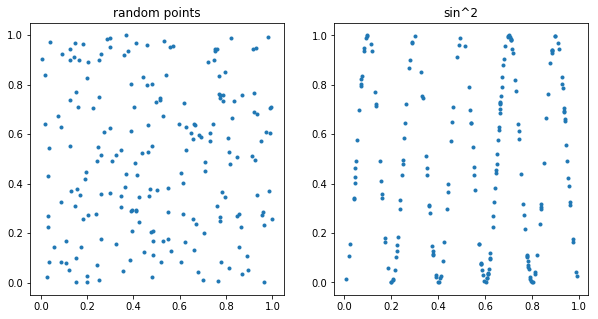

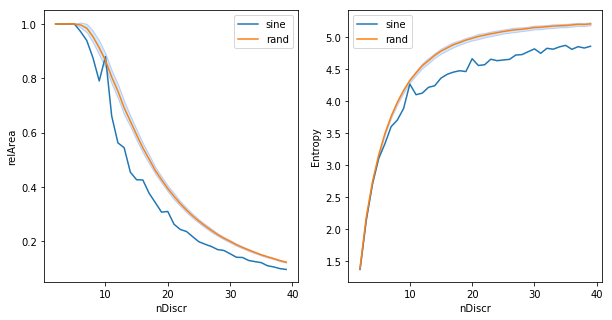

In [16]:

    


NDIM = 2
NDATA = 200
xMin = -0.00001 * np.ones(NDIM)
xMax = 1.00001 * np.ones(NDIM)
nDiscrArr = np.array(list(range(2, 40)))
nDiscrPoint = len(nDiscrLst)

#########################
# Random data
#########################
N_RAND_SAMPLE = 100
relAreaArrRandom = np.zeros((nDiscrPoint, N_RAND_SAMPLE))
binEntrArrRandom = np.zeros((nDiscrPoint, N_RAND_SAMPLE))

for iSample in range(N_RAND_SAMPLE):
    dataRand = np.random.uniform(0, 1, 2*NDATA).reshape(NDATA, 2)
    for iDiscr in range(nDiscrPoint):
        relArea, binEntr = binnedEntropy(dataRand, xMin, xMax, nDiscrArr[iDiscr])
        relAreaArrRandom[iDiscr][iSample] = relArea
        binEntrArrRandom[iDiscr][iSample] = binEntr
        
relAreaArrRandomMean = np.sum(relAreaArrRandom, axis=1) / N_RAND_SAMPLE
relAreaArrRandomVar = (np.sum(relAreaArrRandom**2, axis=1) - N_RAND_SAMPLE * relAreaArrRandomMean**2)/(N_RAND_SAMPLE-1)
relAreaArrRandomStd = np.sqrt(relAreaArrRandomVar*(N_RAND_SAMPLE-1) / (N_RAND_SAMPLE-1.5))

binEntrArrRandomMean = np.sum(binEntrArrRandom, axis=1) / N_RAND_SAMPLE
binEntrArrRandomVar = (np.sum(binEntrArrRandom**2, axis=1) - N_RAND_SAMPLE * binEntrArrRandomMean**2)/(N_RAND_SAMPLE-1)
binEntrArrRandomStd = np.sqrt(binEntrArrRandomVar*(N_RAND_SAMPLE-1) / (N_RAND_SAMPLE-1.5))

#########################
# Sine
#########################
#xSine = np.linspace(0, 1, NDATA)
#ySine = np.sin(xSine * np.pi)
xSine = np.random.uniform(0, 1, NDATA)
ySine = np.sin(xSine * 5 * np.pi)**2
dataSine = np.vstack((xSine, ySine)).transpose()

relAreaArrSine = np.zeros(nDiscrPoint)
binEntrArrSine = np.zeros(nDiscrPoint)

for iDiscr in range(nDiscrPoint):
    relArea, binEntr = binnedEntropy(dataSine, xMin, xMax, nDiscrArr[iDiscr])
    relAreaArrSine[iDiscr] = relArea
    binEntrArrSine[iDiscr] = binEntr


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(dataRand[:, 0], dataRand[:, 1], '.')
ax[1].plot(dataSine[:, 0], dataSine[:, 1], '.')
ax[0].set_title("random points")
ax[1].set_title("sin^2")
plt.show()
    
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_xlabel("nDiscr")
ax[0].set_ylabel("relArea")
ax[0].plot(nDiscrLst, relAreaArrSine, label="sine")
ax[0].plot(nDiscrLst, relAreaArrRandomMean, label="rand")
ax[0].fill_between(nDiscrLst,
                relAreaArrRandomMean-relAreaArrRandomStd,
                relAreaArrRandomMean+relAreaArrRandomStd,
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
ax[0].legend()

ax[1].set_xlabel("nDiscr")
ax[1].set_ylabel("Entropy")
ax[1].plot(nDiscrLst, binEntrArrSine, label="sine")
ax[1].plot(nDiscrLst, binEntrArrRandomMean, label="rand")
ax[1].fill_between(nDiscrLst,
                binEntrArrRandomMean-binEntrArrRandomStd,
                binEntrArrRandomMean+binEntrArrRandomStd,
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)


ax[1].legend()
plt.show()

**Null Hypotesis**: Data was generated from a distribution, which is a product of its marginal 1D probability distributions.

**Strategy**:
1. Get original multidimensional data X
2. Compute marginal empirical CDF for each dimension $i$ from $X_i$
3. Generate surrogate data for dimension independently, same amount as X
4. Compute entropy of data using several bin numbers
5. Compute entropy of surrogate using several bin numbers. Repeat multiple times to get bootstrap variance
6. Plot data entropy vs surrogate entropy
  * For small discretizations, both entropies will be equal to 1 due to coarseness
  * For large discretizations, entropies will be equal due to one data point per bin
  * For middle discretizations, entropy of data should be significantly smaller than surrogate, because it would naturally non-uniformly cover the phase-space.


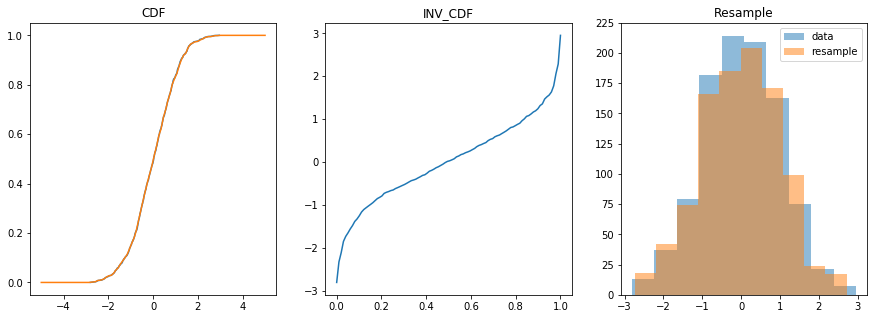

In [119]:
def edf(data1Dsorted, x):
    return np.searchsorted(data1Dsorted, x) / len(data1Dsorted)

def invCDF(data1Dsorted, p):
    return data1Dsorted[min(int(p * len(data1Dsorted)), len(data1Dsorted)-1)]

NDATA = 1000
data = np.random.normal(0, 1, NDATA)
dataSorted = np.sort(data)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

# Plot CDF
dataSample = np.linspace(-5,5,100)
dataCDF = np.linspace(0, 1, NDATA)
ax[0].plot(dataSorted, dataCDF)
ax[0].plot(dataSample, edf(dataSorted, dataSample))
ax[0].set_title("CDF")

# Plot inverse CDF
pArr = np.linspace(0, 1, 100)
invCDFarr = [invCDF(dataSorted, p) for p in pArr]
ax[1].plot(pArr, invCDFarr)
ax[1].set_title("INV_CDF")

# Sample from inverse CDF
dataUniform = np.random.uniform(0, 1, NDATA)
dataSampleInvCDF = [invCDF(dataSorted, p) for p in dataUniform]
ax[2].hist(data, alpha=0.5, label="data")
ax[2].hist(dataSampleInvCDF, alpha=0.5, label="resample")
ax[2].set_title("Resample")
ax[2].legend()

plt.show()

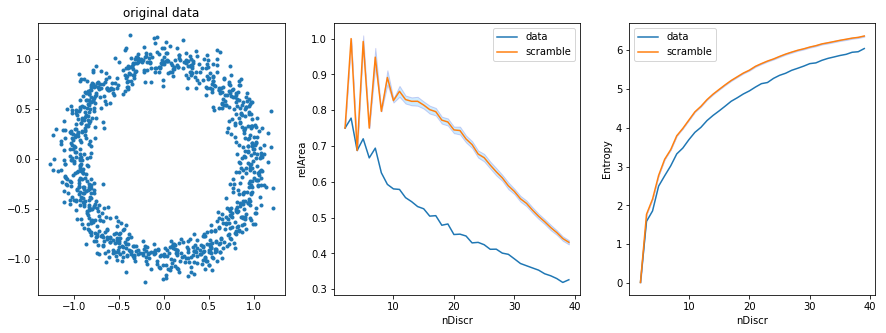

In [17]:
import random
# Create data for noisy circular process
NDATA = 1000
theta = np.random.uniform(0, 1, NDATA)
er = np.random.normal(0, 0.1, NDATA)
x = (1+er)*np.cos(2*np.pi*theta)
y = (1+er)*np.sin(2*np.pi*theta)
data = np.vstack((x, y)).transpose()


# Compute binned entropy for actual data
nDiscrLst = np.array(list(range(2, 40)))
realEntr = binnedEntropyCurves(data, nDiscrLst)

# Compute binned entropy for scrambled data
N_SCRAMBLE = 100
surrEntrMean, surrEntrStd = binnedEntropyCurvesSurrogate(data, nDiscrLst, N_SCRAMBLE, "shuffle")


fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(x, y, '.')
ax[0].set_title("original data")

ax[1].set_xlabel("nDiscr")
ax[1].set_ylabel("relArea")
ax[1].plot(nDiscrLst, realEntr[:, 0], label="data")
ax[1].plot(nDiscrLst, surrEntrMean[:, 0], label="scramble")
ax[1].fill_between(nDiscrLst,
                surrEntrMean[:, 0]-surrEntrStd[:, 0],
                surrEntrMean[:, 0]+surrEntrStd[:, 0],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
ax[1].legend()

ax[2].set_xlabel("nDiscr")
ax[2].set_ylabel("Entropy")
ax[2].plot(nDiscrLst, realEntr[:, 1], label="data")
ax[2].plot(nDiscrLst, surrEntrMean[:, 1], label="scramble")
ax[2].fill_between(nDiscrLst,
                surrEntrMean[:, 1]-surrEntrStd[:, 1],
                surrEntrMean[:, 1]+surrEntrStd[:, 1],
                alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                antialiased=True)
ax[2].legend()

plt.show()